In [12]:
import pandas as pd
import numpy as np
import time
import json
from typing import Iterable, Dict, Any, List, Optional
import requests
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt


In [8]:
import requests

def _props_dict(item):
    props = {}
    plist = (item.get("propertyConceptList") or {}).get("propertyConcept") or []
    for p in plist:
        k = (p.get("propName") or "").strip()
        v = (p.get("propValue") or "").strip()
        if k:
            props[k.upper()] = v
    return props

def _first_match(props, *keys_or_contains):
    for key in keys_or_contains:
        if key in props:
            return props[key]
    for key in props:
        for needle in keys_or_contains:
            if needle in key:
                return props[key]
    return None

def _rxnorm_names_from_rxcui(rxcui):
    base = "https://rxnav.nlm.nih.gov/REST"
    url = f"{base}/rxcui/{rxcui}/allProperties.json"
    resp = requests.get(url, params={"prop": "names"}, timeout=10)
    resp.raise_for_status()
    data = resp.json() or {}
    props = (data.get("propConceptGroup") or {}).get("propConcept") or []
    names = [(p.get("propName"), p.get("propValue")) for p in props]

    brand = None
    for code, val in names:
        if (code or "").upper() in ("BN", "SBD", "SBDF", "SBDG") and val:
            brand = val
            break

    generic = None
    for code, val in names:
        if (code or "").upper() in ("IN", "SCD", "SCDF", "SCDC") and val:
            generic = val
            break

    if generic is None:
        url2 = f"{base}/rxcui/{rxcui}/property.json"
        r2 = requests.get(url2, params={"propName": "RxNorm Name"}, timeout=10)
        if r2.ok:
            dd = r2.json() or {}
            generic = (dd.get("propConceptGroup") or {}).get("propConcept", [{}])[0].get("propValue")

    return brand, generic

def get_names_for_ndc(ndc_code, ndcstatus="ALL"):
    """
    Returns a dict with:
      - ndc11
      - brand_name
      - product_type
      - generic_name
      - labeler
      - rxcui
    Uses RxCUI fallbacks to fill brand/generic when missing in NDC properties.
    """
    ndc_url = "https://rxnav.nlm.nih.gov/REST/ndcproperties.json"
    r = requests.get(ndc_url, params={"id": ndc_code, "ndcstatus": ndcstatus}, timeout=10)
    r.raise_for_status()
    data = r.json() or {}
    items = (data.get("ndcPropertyList") or {}).get("ndcProperty") or []
    if not items:
        return {
            "ndc11": None,
            "brand_name": None,
            "product_type": None,
            "generic_name": None,
            "labeler": None,
            "rxcui": None,
        }

    # pick richest item (prefer one with explicit proprietary/nonproprietary if present)
    best = None
    for it in items:
        props = _props_dict(it)
        if "PROPRIETARYNAME" in props or "NONPROPRIETARYNAME" in props:
            best = it
            break
    if best is None:
        best = items[0]

    props = _props_dict(best)
    rxcui = best.get("rxcui")
    ndc11 = best.get("ndcItem")  # RxNav’s NDC11 field

    # direct reads
    brand = _first_match(props, "PROPRIETARYNAME", "PROPRIETARY NAME", "PROPRIETARY")
    generic = _first_match(props, "NONPROPRIETARYNAME", "NONPROPRIETARY NAME", "NONPROPRIETARY")
    product_type = _first_match(props, "PRODUCTTYPENAME", "PRODUCT TYPE")
    labeler = _first_match(props, "LABELER", "LABELERNAME", "LABELER NAME")

    # fallbacks via RxCUI
    if (not brand or not generic) and rxcui:
        rx_brand, rx_generic = _rxnorm_names_from_rxcui(rxcui)
        brand = brand or rx_brand
        generic = generic or rx_generic

    return {
        "ndc11": ndc11,
        "brand_name": brand,
        "product_type": product_type,   # e.g., HUMAN PRESCRIPTION DRUG
        "generic_name": generic,
        "labeler": labeler,
        "rxcui": rxcui,
    }

# ---- Example usage
if __name__ == "__main__":
    summary = get_names_for_ndc("00003-0894", ndcstatus="ALL")

print("NDC11:", summary["ndc11"])
print("Brand name:", summary["brand_name"])
print("Product type:", summary["product_type"])
print("Generic name:", summary["generic_name"])
print("Labeler:", summary["labeler"])
print("RxCUI:", summary["rxcui"])


NDC11: 00003089421
Brand name: None
Product type: None
Generic name: apixaban 5 MG Oral Tablet [Eliquis]
Labeler: E.R. Squibb & Sons, L.L.C.
RxCUI: 1364447


In [9]:
# Reading and exploring drug utilization data 
df = pd.read_csv('SDUD2017.csv')
df_xx=df[df['State'] == 'XX']
print(len(df))

#PC_idx=np.arange(len(df["NDC"].unique()))
#print(len(PC_idx))
# Too many unique NDC codes to handle all of them in a matrix like FAF dataset. 

# Remove invalid state code 'XX'
df = df[df['State'] != 'XX']
print(len(df))

# Grouping by 'State' and summing 'Units Reimbursed' and 'Number of Prescriptions'
state_summary = df.groupby('State')[['Units Reimbursed', 'Number of Prescriptions']].sum()
print(state_summary)

total_units = state_summary['Units Reimbursed'].sum()
total_prescriptions = state_summary['Number of Prescriptions'].sum()
print("\nTotal Units Reimbursed across all states:", total_units)
print("Total Number of Prescriptions across all states:", total_prescriptions)

# Sorting by 'Units Reimbursed' in descending order and displaying the top 10 states
top_states_units = state_summary.sort_values(by='Units Reimbursed', ascending=False).head(10)
print("\nTop 10 States by Units Reimbursed:")
print(top_states_units)

# Sorting by 'Number of Prescriptions' in descending order and displaying the top 10 states
top_states_prescriptions = state_summary.sort_values(by='Number of Prescriptions', ascending=False).head(10)
print("\nTop 10 States by Number of Prescriptions:")
print(top_states_prescriptions)

# print(df_xx)
print(len(df_xx))

wp = df_xx.groupby('State')[['Units Reimbursed', 'Number of Prescriptions']].sum()
print(wp)

C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_28640\3895576800.py:2: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('SDUD2017.csv')


4789471
4516042
       Units Reimbursed  Number of Prescriptions
State                                           
AK         9.388931e+07                1432713.0
AL         4.705494e+08                7510339.0
AR         3.042890e+08                5234571.0
AZ         9.279193e+08               17094220.0
CA         6.463579e+09               99026365.0
CO         5.270665e+08                8326556.0
CT         5.392237e+08                9329782.0
DC         1.177594e+08                2281402.0
DE         1.267123e+08                2420992.0
FL         1.980574e+09               30149124.0
GA         1.035827e+09               17282659.0
HI         3.101769e+09                2967089.0
IA         3.243602e+08                5892948.0
ID         1.350231e+08                2284366.0
IL         1.627276e+09               29255136.0
IN         1.022827e+09               16760723.0
KS         2.902815e+08                4520095.0
KY         1.279481e+09               23531086.0
LA  

In [13]:

#Trying a function to encapsulate the above logic for reusability

def preliminar(file_path):
    """
    Reads a CSV file, processes the drug utilization data, and prints summaries with the year.
    
    Args:
        file_path (str): Path to the CSV file.
    """
    # Extracting the year from the file path
    year = file_path[4:8]
    
    # Reading the CSV file
    df = pd.read_csv(file_path)
    print(f"Year {year}: Total rows in the dataset: {len(df)}")
    
    # Filtering rows with invalid state code 'XX'
    df_xx = df[df['State'] == 'XX']
    print(f"Year {year}: Rows with invalid state code 'XX': {len(df_xx)}")
    
    # Removing rows with invalid state code 'XX'
    df = df[df['State'] != 'XX']
    print(f"Year {year}: Rows after removing invalid state code 'XX': {len(df)}")
    
    # Grouping by 'State' and summing 'Units Reimbursed' and 'Number of Prescriptions'
    state_summary = df.groupby('State')[['Units Reimbursed', 'Number of Prescriptions']].sum()
    print(f"\nYear {year}: State Summary:")
    print(state_summary)
    
    # Calculating total units reimbursed and total prescriptions
    total_units = state_summary['Units Reimbursed'].sum()
    total_prescriptions = state_summary['Number of Prescriptions'].sum()
    print(f"\nYear {year}: Total Units Reimbursed across all states: {total_units}")
    print(f"Year {year}: Total Number of Prescriptions across all states: {total_prescriptions}")
    
    # Sorting by 'Units Reimbursed' in descending order and displaying the top 10 states
    top_states_units = state_summary.sort_values(by='Units Reimbursed', ascending=False).head(10)
    print(f"\nYear {year}: Top 10 States by Units Reimbursed:")
    print(top_states_units)
    
    # Sorting by 'Number of Prescriptions' in descending order and displaying the top 10 states
    top_states_prescriptions = state_summary.sort_values(by='Number of Prescriptions', ascending=False).head(10)
    print(f"\nYear {year}: Top 10 States by Number of Prescriptions:")
    print(top_states_prescriptions)
    
    # Summarizing rows with invalid state code 'XX'
    wp = df_xx.groupby('State')[['Units Reimbursed', 'Number of Prescriptions']].sum()
    print(f"\nYear {year}: Summary for rows with invalid state code 'XX':")
    print(wp)
    
    # Comparison between total_units and wp['Units Reimbursed']
    if not wp.empty:
        xx_units = wp['Units Reimbursed'].iloc[0] #index is correct
        xx_prescriptions = wp['Number of Prescriptions'].iloc[0]
        
        units_difference_percentage = ((total_units - xx_units) / xx_units) * 100
        prescriptions_difference_percentage = ((total_prescriptions - xx_prescriptions) / xx_prescriptions) * 100
        
        print(f"\nYear {year}: Comparison with 'XX':")
        print(f"Percentage difference in Units Reimbursed: {units_difference_percentage:.2f}%")
        print(f"Percentage difference in Number of Prescriptions: {prescriptions_difference_percentage:.2f}%")
    else:
        print(f"\nYear {year}: No data available for state code 'XX'.")
    
    # Correlation Analysis
    correlation = state_summary['Units Reimbursed'].corr(state_summary['Number of Prescriptions'])
    print(f"\nYear {year}: Correlation between 'Units Reimbursed' and 'Number of Prescriptions': {correlation:.2f}")

# Example usage:
preliminar('SDUD2010.csv')
preliminar('SDUD2011.csv')
preliminar('SDUD2012.csv')
preliminar('SDUD2013.csv')
preliminar('SDUD2014.csv')
preliminar('SDUD2015.csv')
preliminar('SDUD2016.csv')
preliminar('SDUD2017.csv')
preliminar('SDUD2018.csv')
preliminar('SDUD2019.csv')
preliminar('SDUD2020.csv')
preliminar('SDUD2021.csv')
preliminar('SDUD2022.csv')
preliminar('SDUD2023.csv')
preliminar('SDUD2024.csv')


C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_28640\2301877779.py:14: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Year 2010: Total rows in the dataset: 3180561
Year 2010: Rows with invalid state code 'XX': 219160
Year 2010: Rows after removing invalid state code 'XX': 2961401

Year 2010: State Summary:
       Units Reimbursed  Number of Prescriptions
State                                           
AK         4.610507e+07                1006168.0
AL         4.821577e+08                8525050.0
AR         2.908855e+08                4788392.0
AZ         6.108745e+08               10514315.0
CA         3.313082e+09               47209227.0
CO         2.174022e+08                3510982.0
CT         3.341199e+08                6221027.0
DC         4.750189e+07                 921075.0
DE         1.105653e+08                1950848.0
FL         1.407399e+09               21512189.0
GA         7.136193e+08               12054077.0
HI         9.107152e+07                1486743.0
IA         2.603105e+08                4298744.0
ID         1.004525e+08                1878922.0
IL         1.454374e+09   

C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_28640\2301877779.py:14: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Year 2012: Total rows in the dataset: 3919542
Year 2012: Rows with invalid state code 'XX': 249782
Year 2012: Rows after removing invalid state code 'XX': 3669760

Year 2012: State Summary:
       Units Reimbursed  Number of Prescriptions
State                                           
AK         5.187565e+07                 948397.0
AL         5.092824e+08                9329787.0
AR         2.906730e+08                4818792.0
AZ         6.285162e+08               10478573.0
CA         3.535286e+09               52106367.0
CO         2.645151e+08                4251612.0
CT         4.072255e+08                7531561.0
DC         1.386383e+08                2787689.0
DE         1.281082e+08                2333448.0
FL         1.657779e+09               25599561.0
GA         9.868878e+08               16392935.0
HI         1.627231e+08                2662301.0
IA         2.824809e+08                4650753.0
ID         1.074618e+08                2093510.0
IL         1.395722e+09   

C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_28640\2301877779.py:14: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Year 2013: Total rows in the dataset: 4132447
Year 2013: Rows with invalid state code 'XX': 257091
Year 2013: Rows after removing invalid state code 'XX': 3875356

Year 2013: State Summary:
       Units Reimbursed  Number of Prescriptions
State                                           
AK         4.902035e+07                 904730.0
AL         4.971545e+08                8918400.0
AR         2.843280e+08                4681409.0
AZ         1.026460e+09               13230305.0
CA         3.721873e+09               55105521.0
CO         3.014459e+08                4714387.0
CT         4.505209e+08                7605416.0
DC         1.138507e+08                2151850.0
DE         1.275894e+08                2311401.0
FL         1.773833e+09               26993162.0
GA         1.064362e+09               16516855.0
HI         1.470152e+08                2353188.0
IA         2.757048e+08                4474734.0
ID         1.174339e+08                2077249.0
IL         9.830261e+08   

C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_28640\2301877779.py:14: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Year 2014: Total rows in the dataset: 4320924
Year 2014: Rows with invalid state code 'XX': 259522
Year 2014: Rows after removing invalid state code 'XX': 4061402

Year 2014: State Summary:
       Units Reimbursed  Number of Prescriptions
State                                           
AK         5.295601e+07                 875986.0
AL         4.393784e+08                7349366.0
AR         3.121499e+08                5235862.0
AZ         7.900745e+08               13834278.0
CA         4.379297e+09               70226459.0
CO         4.472447e+08                7164166.0
CT         4.925703e+08                8307187.0
DC         1.193892e+08                2261584.0
DE         1.313141e+08                2373600.0
FL         1.864379e+09               28231143.0
GA         1.003843e+09               16757754.0
HI         1.519822e+08                2601478.0
IA         3.570868e+08                5978958.0
ID         1.159932e+08                2130083.0
IL         1.094080e+09   

C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_28640\2301877779.py:14: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Year 2017: Total rows in the dataset: 4789471
Year 2017: Rows with invalid state code 'XX': 273429
Year 2017: Rows after removing invalid state code 'XX': 4516042

Year 2017: State Summary:
       Units Reimbursed  Number of Prescriptions
State                                           
AK         9.388931e+07                1432713.0
AL         4.705494e+08                7510339.0
AR         3.042890e+08                5234571.0
AZ         9.279193e+08               17094220.0
CA         6.463579e+09               99026365.0
CO         5.270665e+08                8326556.0
CT         5.392237e+08                9329782.0
DC         1.177594e+08                2281402.0
DE         1.267123e+08                2420992.0
FL         1.980574e+09               30149124.0
GA         1.035827e+09               17282659.0
HI         3.101769e+09                2967089.0
IA         3.243602e+08                5892948.0
ID         1.350231e+08                2284366.0
IL         1.627276e+09   

In [14]:
#Using population data (BOTH DATASETS)

# Load population data (2010-2019 and 2020-2024)
pop0_df = pd.read_excel("../Population/20102020_pop.xlsx", engine="openpyxl")
pop1_df = pd.read_excel("../Population/20202024_pop.xlsx", engine="openpyxl")

def _clean_pop(df):
    df = df.copy()
    df['Geographic Area'] = df['Geographic Area'].str.replace('.', '', regex=False).str.strip()
    return df

pop0_df = _clean_pop(pop0_df)
pop1_df = _clean_pop(pop1_df)

# Combine year columns horizontally by Geographic Area
pop_df = pop0_df.merge(pop1_df, on='Geographic Area', how='outer')

# Drop totally empty area rows
pop_df = pop_df[pop_df['Geographic Area'].notna()].reset_index(drop=True)

# Coerce numeric columns
for c in pop_df.columns:
    if c != 'Geographic Area':
        pop_df[c] = pd.to_numeric(pop_df[c], errors='coerce')

# Order columns: Geographic Area, then years (keeping B before final year where applicable)
def _col_key(c):
    if c == 'Geographic Area':
        return (0, 0, 0)
    sc = str(c)
    base = sc.rstrip('B')
    if base.isdigit():
        return (1, int(base), 0 if sc.endswith('B') else 1)
    return (2, sc, 0)

ordered_cols = ['Geographic Area'] + sorted([c for c in pop_df.columns if c != 'Geographic Area'], key=_col_key)
pop_df = pop_df[ordered_cols]

print(pop_df.head())

  Geographic Area       2010B        2010        2011        2012        2013  \
0         Alabama   4780118.0   4788095.0   4812576.0   4839947.0   4865253.0   
1          Alaska    710246.0    714015.0    722513.0    731106.0    738054.0   
2         Arizona   6392292.0   6401304.0   6443158.0   6501800.0   6555926.0   
3        Arkansas   2916029.0   2921546.0   2938773.0   2948793.0   2954563.0   
4      California  37254522.0  37322523.0  37651212.0  37971412.0  38292557.0   

         2014        2015        2016        2017        2018        2019  \
0   4887757.0   4909177.0   4931579.0   4953096.0   4977088.0   5003778.0   
1    737634.0    739120.0    743397.0    741937.0    737710.0    734820.0   
2   6629890.0   6705607.0   6793278.0   6872380.0   6964300.0   7067695.0   
3   2961050.0   2970210.0   2980475.0   2990702.0   2997195.0   3004206.0   
4  38637421.0  38966939.0  39223789.0  39424315.0  39535920.0  39547995.0   

        2020B        2020        2021        2022 

In [15]:
#Merging datasets
from pathlib import Path

# 1. Aggregate utilization per State-Year
def build_utilization_dataframe(file_paths):
    frames = []
    usecols = ['State','Units Reimbursed','Number of Prescriptions']
    for fp in file_paths:
        year = int(Path(fp).stem[-4:])  # assumes pattern SDUDYYYY.csv
        df = pd.read_csv(fp, usecols=usecols)
        df = df[df['State'].ne('XX')]  # drop invalid
        state_summary = df.groupby('State', as_index=False).sum()
        state_summary['Year'] = year
        frames.append(state_summary)
    return pd.concat(frames, ignore_index=True)

csv_years = list(range(2010, 2025))  # adjust if more years available
csv_files = [f"SDUD{y}.csv" for y in csv_years]
util_df = build_utilization_dataframe(csv_files)

# 2. Reshape population data to long format (ensure pop_df already loaded earlier)
# CHANGED: coerce column name to str before isdigit() to avoid AttributeError on int columns; keep only 4-digit years
pop_year_cols = [c for c in pop_df.columns if str(c).isdigit() and len(str(c)) == 4]
pop_long = pop_df.melt(id_vars=['Geographic Area'], value_vars=pop_year_cols,
                       var_name='Year', value_name='Population')
pop_long['Year'] = pop_long['Year'].astype(int)

# 3. Map full state names to postal abbreviations
state_map = {
 'AL':'Alabama','AK':'Alaska','AZ':'Arizona','AR':'Arkansas','CA':'California','CO':'Colorado','CT':'Connecticut',
 'DE':'Delaware','DC':'District of Columbia','FL':'Florida','GA':'Georgia','HI':'Hawaii','ID':'Idaho','IL':'Illinois',
 'IN':'Indiana','IA':'Iowa','KS':'Kansas','KY':'Kentucky','LA':'Louisiana','ME':'Maine','MD':'Maryland','MA':'Massachusetts',
 'MI':'Michigan','MN':'Minnesota','MS':'Mississippi','MO':'Missouri','MT':'Montana','NE':'Nebraska','NV':'Nevada','NH':'New Hampshire',
 'NJ':'New Jersey','NM':'New Mexico','NY':'New York','NC':'North Carolina','ND':'North Dakota','OH':'Ohio','OK':'Oklahoma','OR':'Oregon',
 'PA':'Pennsylvania','RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota','TN':'Tennessee','TX':'Texas','UT':'Utah','VT':'Vermont',
 'VA':'Virginia','WA':'Washington','WV':'West Virginia','WI':'Wisconsin','WY':'Wyoming'
}
full_to_abbrev = {v:k for k,v in state_map.items()}
pop_long['State'] = pop_long['Geographic Area'].map(full_to_abbrev)
pop_long = pop_long.dropna(subset=['State'])

# 4. Keep only population years that exist in utilization
pop_long = pop_long[pop_long['Year'].isin(util_df['Year'].unique())]

# 5. Merge
merged = util_df.merge(pop_long[['State','Year','Population']], on=['State','Year'], how='left')

# 6. Reorder + add normalized columns
merged = merged[['State','Year','Population','Units Reimbursed','Number of Prescriptions']]

merged['N Prescriptions norm'] = merged['Number of Prescriptions'] / merged['Population']
merged['N Units reimbursed norm'] = merged['Units Reimbursed'] / merged['Population']

# 7. Inspect
print(merged.head())
print('\nShape:', merged.shape)

# Just checking
only2010 = merged[merged['Year']==2010]
onlyIN= merged[merged['State']=='IN']
#print(only2010)
print('\n2010 Shape:', only2010.shape)
print(onlyIN)
# 'merged' now contains the requested combined dataframe


  State  Year  Population  Units Reimbursed  Number of Prescriptions  \
0    AK  2010    714015.0      4.610507e+07                1006168.0   
1    AL  2010   4788095.0      4.821577e+08                8525050.0   
2    AR  2010   2921546.0      2.908855e+08                4788392.0   
3    AZ  2010   6401304.0      6.108745e+08               10514315.0   
4    CA  2010  37322523.0      3.313082e+09               47209227.0   

   N Prescriptions norm  N Units reimbursed norm  
0              1.409169                64.571570  
1              1.780468               100.699285  
2              1.638993                99.565613  
3              1.642527                95.429691  
4              1.264899                88.768972  

Shape: (767, 7)

2010 Shape: (51, 7)
    State  Year  Population  Units Reimbursed  Number of Prescriptions  \
15     IN  2010   6491385.0      9.851722e+08               12146278.0   
66     IN  2011   6521409.0      9.501631e+08               11688407.0   
1


Correlation between 'N Units reimbursed norm' and 'N Prescriptions norm': 0.49


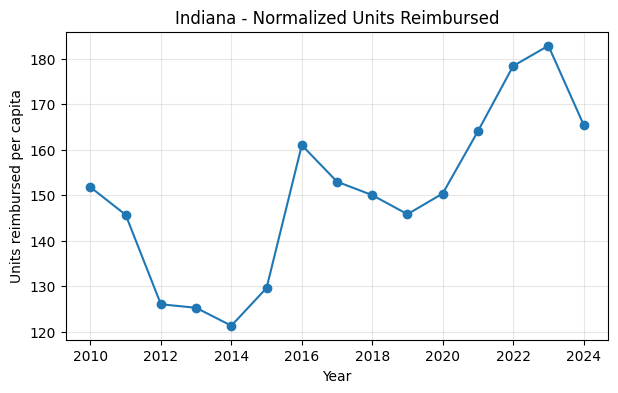

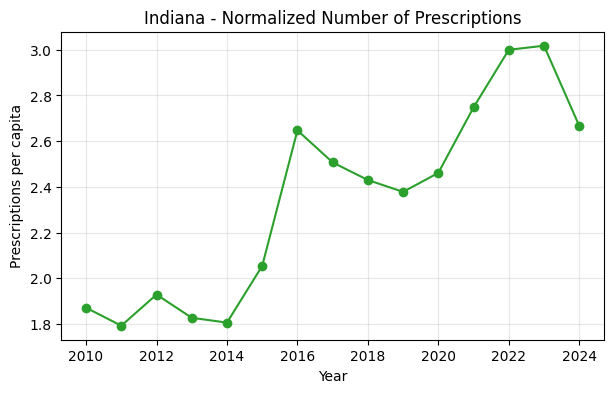

In [ ]:
# look at correlations and patterns
corr_pop = merged['N Units reimbursed norm'].corr(merged['N Prescriptions norm'])
print(f"\nCorrelation between 'N Units reimbursed norm' and 'N Prescriptions norm': {corr_pop:.2f}")
# Filter data for Indiana
indiana_data = merged.loc[merged['State'] == 'IN'].sort_values('Year').dropna(
    subset=['N Units reimbursed norm', 'N Prescriptions norm']
)

# Line chart 1: Normalized Units Reimbursed
#plt.figure(figsize=(7,4))
#plt.plot(indiana_data['Year'], indiana_data['N Units reimbursed norm'], marker='o', color='tab:blue')
#plt.title('Indiana - Normalized Units Reimbursed')
#plt.xlabel('Year')
#plt.ylabel('Units reimbursed per capita')
#plt.grid(alpha=0.3)

# Line chart 2: Normalized Number of Prescriptions
#plt.figure(figsize=(7,4))
#plt.plot(indiana_data['Year'], indiana_data['N Prescriptions norm'], marker='o', color='tab:green')
#plt.title('Indiana - Normalized Number of Prescriptions')
#plt.xlabel('Year')
#plt.ylabel('Prescriptions per capita')
#plt.grid(alpha=0.3)


